In [1]:
# 確率的勾配降下法
class SGD :
    def __init__(self, lr=0.01) :
        self.lr = lr
        
    def update(self, params, grads) : # ←SGDではこいつが繰り返し呼ばれる
        for key in params.key() :
            params[key] -= self.lr * grads[key]

In [3]:
# モーメンタム
import numpy as np

class Momentum :
    def __init__(self, lr=0.01, momentum=0.9) :
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads) :
        if self.v is None :
            self.v = {}
            for key, val in params.items() :
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys() :
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [4]:
# 学習係数の減衰を用いた学習
import numpy as np

class AdaGrad :
    def __init__(self, lr=0.01) :
        self.lr = lr
        self.h = None
        
    def update(self, params, grads) :
        if self.h is None :
            self.h = {}
            for key, val in params.items() :
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

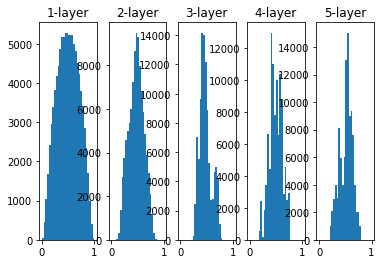

In [5]:
# 隠れ層のアクティベーション分布
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100 # 各隠れ層のノードの数
hidden_layer_size = 5 # 隠れ層が5層
activations = {}

for i in range(hidden_layer_size) :
    if i != 0 :
        x = activations[i-1]
        
    #w = np.random.randn(node_num, node_num) * 1 # 標準偏差1
    #w = np.random.randn(node_num, node_num) * 0.01 # 標準偏差0.01
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # xavierの初期値
    
    z = np.dot(x,w)
    a = sigmoid(z)
    activations[i] = a
    
for i, a in activations.items() :
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

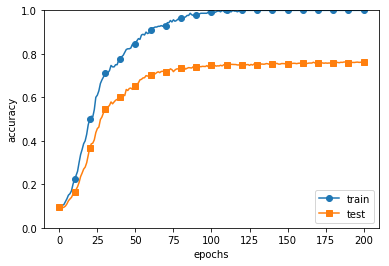

In [8]:
# 過学習を発生させる

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100,100,100,100,100,100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000) :
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0 :
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs :
            break
            
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [9]:
# 過学習の抑制手法 Dropout

class Dropout :
    def __init__(self, dropout_ratio=0.5) :
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True) :
        if train_flg :
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else :
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout) :
        return dout * self.mask

In [10]:
# ハイパーパラメータの性能評価のための検証データ

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 訓練データをシャッフル
x_train, t_train = shuffle_dataset(x_train, t_train)

# 検証データの分割
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]